# Walmart Store Sales Forecasting

### Importing Libraries

In [65]:
import warnings
import itertools

import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('bmh')

## 1. Knowing data

### 1.1 About time series
#### 1.1.1 Loading data

In [66]:
train = pd.read_csv("C:/Users/Christine Liou/Documents/Walmart/train.csv")

In [67]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [68]:
print("train:", train.shape)

train: (421570, 5)


#### 1.1.2 Data Preprocessing

In [69]:
# changing datatype to datetime format
train['Date']=pd.to_datetime(train['Date'])

In [70]:
# Data Exploratory
train['Month']=train['Date'].dt.month
train['Year']=train['Date'].dt.year
train['Dayofweek']=train['Date'].dt.dayofweek

In [71]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Month,Year,Dayofweek
0,1,1,2010-02-05,24924.50,False,2,2010,4
1,1,1,2010-02-12,46039.49,True,2,2010,4
2,1,1,2010-02-19,41595.55,False,2,2010,4
3,1,1,2010-02-26,19403.54,False,2,2010,4
4,1,1,2010-03-05,21827.90,False,3,2010,4


In [72]:
# set the dates as the index of the dataframe, so that it can be treated as a time-series dataframe
train.set_index('Date',inplace=True)


In [73]:
train.isnull().sum()

Store           0
Dept            0
Weekly_Sales    0
IsHoliday       0
Month           0
Year            0
Dayofweek       0
dtype: int64

In [74]:
train['Weekly_Sales'].describe()

count    421570.000000
mean      15981.258123
std       22711.183519
min       -4988.940000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64

#### 1.1.3 Visualizing data

In [75]:
# extract out the time-series
sales=train.groupby('Date')['Weekly_Sales'].sum()
sales.head()

Date
2010-02-05    49750740.50
2010-02-12    48336677.63
2010-02-19    48276993.78
2010-02-26    43968571.13
2010-03-05    46871470.30
Name: Weekly_Sales, dtype: float64

Text(0, 0.5, 'Weekly_Sales')

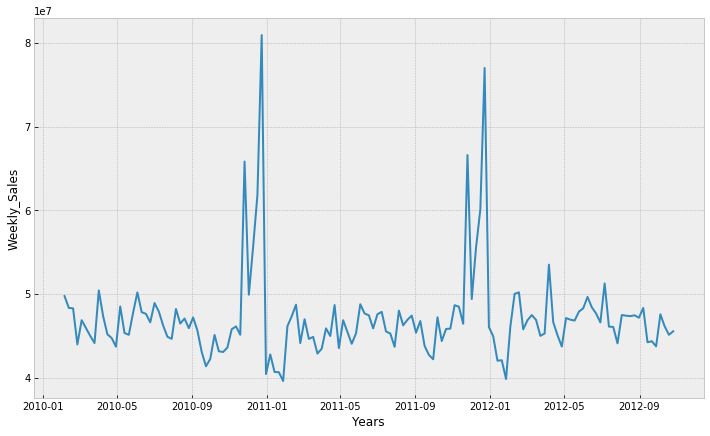

In [76]:
plt.figure(figsize=(12, 7))
plt.plot(sales)
plt.xlabel('Years')
plt.ylabel('Weekly_Sales')

In [77]:
monthly_sales = pd.pivot_table(train, values = "Weekly_Sales", columns = "Year", index = "Month")
monthly_sales = monthly_sales.reindex(index = [1,2,3,4,5,6,7,8,9,10,11,12])
monthly_sales

Year,2010,2011,2012
Month,,,
1,NaN,13997.773991,14252.698030
2,16076.778701,15870.141203,16077.647710
3,15432.626612,15182.972005,15589.875454
4,15745.551340,15361.895495,15890.394983
5,15996.481695,15367.864481,15967.389566
6,16486.250953,16188.124643,16309.247563
7,15972.812718,15724.738313,15893.325343
8,16171.689295,16030.542478,16002.348874
9,15120.086691,14961.570247,15239.205709


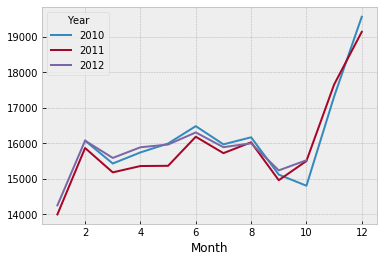

In [78]:
monthly_sales.plot()

### 1.2 About other features 
#### 1.2.1 Loading Data

In [79]:
features = pd.read_csv("C:/Users/Christine Liou/Documents/Walmart/features.csv")
train_set = pd.read_csv("C:/Users/Christine Liou/Documents/Walmart/train.csv")

In [80]:
df = train_set.merge(features, left_on =['Store','Date'] ,right_on = ['Store','Date'], how = 'left')

In [81]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [82]:
df.shape

(421570, 15)

#### 1.2.2 Visualizing data

[Text(0.5, 0, 'Weekly_Sales'),
 Text(1.5, 0, 'Temperature'),
 Text(2.5, 0, 'Fuel_Price'),
 Text(3.5, 0, 'CPI')]

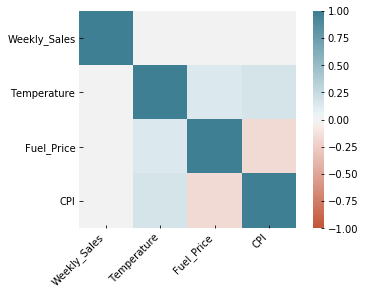

In [83]:
corr = df[['Weekly_Sales','Temperature','Fuel_Price','CPI']].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

## 2. Building models
###  2.1 Timeseries Forecasting by FBProphet

In [84]:
#!conda  install -c conda-forge fbprophet --yes
#!pip install fbprophet
from fbprophet import Prophet #you need to install fbprophet using pip install

In [85]:
train=train.groupby('Date')[['Weekly_Sales']].sum()

In [86]:
train['ds'] = train.index

In [87]:
train.head()

,Weekly_Sales,ds
Date,,
2010-02-05,49750740.50,2010-02-05
2010-02-12,48336677.63,2010-02-12
2010-02-19,48276993.78,2010-02-19
2010-02-26,43968571.13,2010-02-26
2010-03-05,46871470.30,2010-03-05


In [88]:
train = train[['ds', 'Weekly_Sales']].rename(columns={'ds': 'ds', 'Weekly_Sales': 'y'})

In [89]:
train.head()

,ds,y
Date,,
2010-02-05,2010-02-05,49750740.50
2010-02-12,2010-02-12,48336677.63
2010-02-19,2010-02-19,48276993.78
2010-02-26,2010-02-26,43968571.13
2010-03-05,2010-03-05,46871470.30


In [90]:
train.shape

(143, 2)

In [91]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2010-02-05 to 2012-10-26
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      143 non-null    datetime64[ns]
 1   y       143 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB


In [92]:
sales_model = Prophet(seasonality_mode='additive',interval_width=0.95)
sales_model.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [93]:
sales_forecast = sales_model.make_future_dataframe(periods=36, freq='MS')
sales_forecast = sales_model.predict(sales_forecast)

In [94]:
sales_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-02-05,4.713498e+07,4.095510e+07,5.446669e+07,4.713498e+07,4.713498e+07,7.063785e+05,7.063785e+05,7.063785e+05,7.063785e+05,7.063785e+05,7.063785e+05,0.0,0.0,0.0,4.784136e+07
1,2010-02-12,4.713199e+07,4.137399e+07,5.553233e+07,4.713199e+07,4.713199e+07,1.412247e+06,1.412247e+06,1.412247e+06,1.412247e+06,1.412247e+06,1.412247e+06,0.0,0.0,0.0,4.854424e+07
2,2010-02-19,4.712901e+07,4.042377e+07,5.379209e+07,4.712901e+07,4.712901e+07,3.230487e+04,3.230487e+04,3.230487e+04,3.230487e+04,3.230487e+04,3.230487e+04,0.0,0.0,0.0,4.716131e+07
3,2010-02-26,4.712603e+07,3.956801e+07,5.247447e+07,4.712603e+07,4.712603e+07,-1.180110e+06,-1.180110e+06,-1.180110e+06,-1.180110e+06,-1.180110e+06,-1.180110e+06,0.0,0.0,0.0,4.594592e+07
4,2010-03-05,4.712304e+07,3.866909e+07,5.244425e+07,4.712304e+07,4.712304e+07,-1.452878e+06,-1.452878e+06,-1.452878e+06,-1.452878e+06,-1.452878e+06,-1.452878e+06,0.0,0.0,0.0,4.567016e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,2015-06-01,4.999394e+07,4.357876e+07,5.701271e+07,4.933669e+07,5.062838e+07,2.139161e+05,2.139161e+05,2.139161e+05,2.139161e+05,2.139161e+05,2.139161e+05,0.0,0.0,0.0,5.020786e+07
175,2015-07-01,5.005013e+07,4.385843e+07,5.721539e+07,4.935936e+07,5.070997e+07,5.057076e+05,5.057076e+05,5.057076e+05,5.057076e+05,5.057076e+05,5.057076e+05,0.0,0.0,0.0,5.055583e+07
176,2015-08-01,5.010818e+07,4.197248e+07,5.552392e+07,4.938682e+07,5.079974e+07,-1.429272e+06,-1.429272e+06,-1.429272e+06,-1.429272e+06,-1.429272e+06,-1.429272e+06,0.0,0.0,0.0,4.867891e+07
177,2015-09-01,5.016624e+07,4.349567e+07,5.710430e+07,4.941463e+07,5.090397e+07,-2.305902e+04,-2.305902e+04,-2.305902e+04,-2.305902e+04,-2.305902e+04,-2.305902e+04,0.0,0.0,0.0,5.014318e+07


<Figure size 1296x432 with 0 Axes>

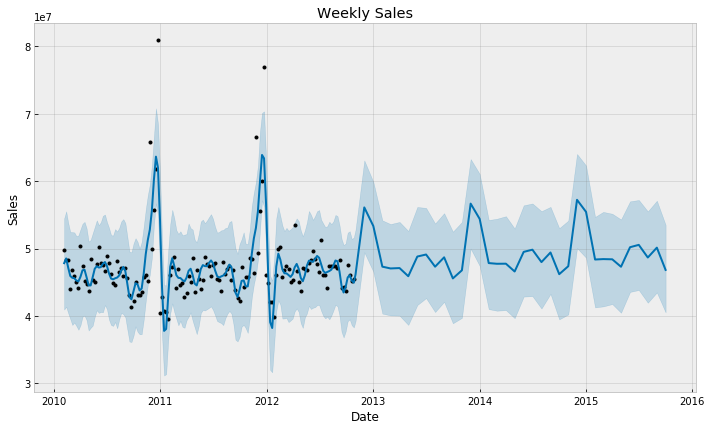

In [95]:
plt.figure(figsize=(18, 6))
sales_model.plot(sales_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Weekly Sales');

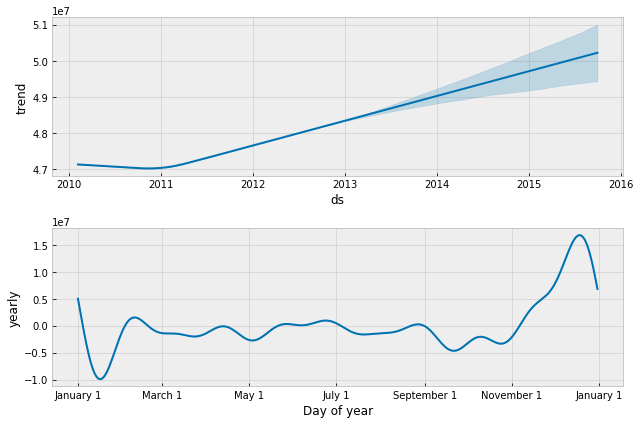

In [96]:
sales_model.plot_components(sales_forecast);

### 2.2 Timeseries Forecasting byARIMA
#### 2.2.1 Dickey-Fuller test

In [97]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
adfuller(sales)

(-5.908297957186321,
 2.67597915898623e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 4314.46014989216)

In [98]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -5.908298e+00
p-value                        2.675979e-07
#lags Used                     4.000000e+00
Number of Observations Used    1.380000e+02
Critical Value (1%)           -3.478648e+00
Critical Value (5%)           -2.882722e+00
Critical Value (10%)          -2.578065e+00
dtype: float64


Though the variation in standard deviation is small, rolling mean is clearly increasing with time and this is not a stationary series. Also, the test statistic is way less than the critical values.

As we observed while plotting the moving average over months that there is a monhly pattern, now, let’s decipher the seasonal component.

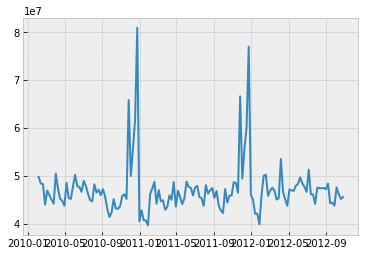

In [99]:
plt.plot(sales)

In [100]:
sales_log = np.log10(sales)

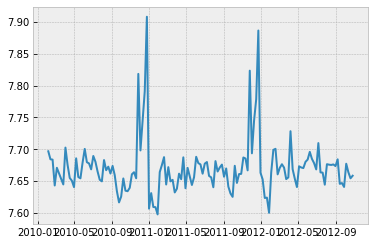

In [101]:
plt.plot(sales_log)

In [102]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_log)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.332826e+00
p-value                        2.878283e-08
#lags Used                     4.000000e+00
Number of Observations Used    1.380000e+02
Critical Value (1%)           -3.478648e+00
Critical Value (5%)           -2.882722e+00
Critical Value (10%)          -2.578065e+00
dtype: float64


In [103]:
sales.diff(1).head()

Date
2010-02-05           NaN
2010-02-12   -1414062.87
2010-02-19     -59683.85
2010-02-26   -4308422.65
2010-03-05    2902899.17
Name: Weekly_Sales, dtype: float64

In [104]:
sales_diff1 = sales.diff(1)
sales_diff1.dropna(inplace=True)

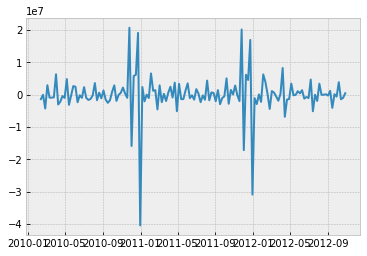

In [105]:
plt.plot(sales_diff1)

In [106]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_diff1)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.699469e+00
p-value                        3.922579e-09
#lags Used                     7.000000e+00
Number of Observations Used    1.340000e+02
Critical Value (1%)           -3.480119e+00
Critical Value (5%)           -2.883362e+00
Critical Value (10%)          -2.578407e+00
dtype: float64


In [107]:
sales_log_diff1 = sales_log.diff(1)
sales_log_diff1.dropna(inplace=True)

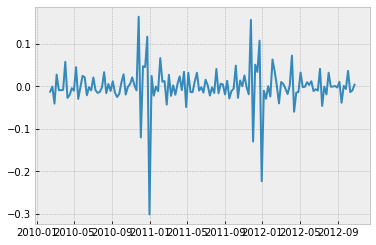

In [108]:
plt.plot(sales_log_diff1)

In [109]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_log_diff1)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.747059e+00
p-value                        3.016343e-09
#lags Used                     7.000000e+00
Number of Observations Used    1.340000e+02
Critical Value (1%)           -3.480119e+00
Critical Value (5%)           -2.883362e+00
Critical Value (10%)          -2.578407e+00
dtype: float64


In [110]:
sales_log_diff2 = sales_log.diff(2)
sales_log_diff2.dropna(inplace=True)

In [111]:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_log_diff2)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -7.558182e+00
p-value                        3.059679e-11
#lags Used                     4.000000e+00
Number of Observations Used    1.360000e+02
Critical Value (1%)           -3.479372e+00
Critical Value (5%)           -2.883037e+00
Critical Value (10%)          -2.578234e+00
dtype: float64


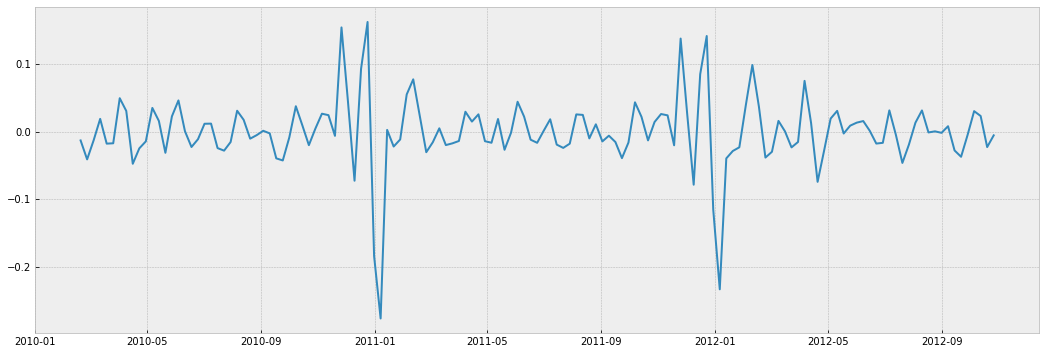

In [112]:
plt.figure(figsize=(18, 6))
plt.plot(sales_log_diff2)

#### 2.2.2 ARIMA Modeling

In [113]:
model = sm.tsa.statespace.SARIMAX(sales_log_diff2, order = (1,0,1), seasonal_order= (1,0,0,12),
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)

In [114]:
results = model.fit()
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                        Weekly_Sales   No. Observations:                  141
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood                 212.406
Date:                             Fri, 06 Nov 2020   AIC                           -416.812
Time:                                     20:52:46   BIC                           -405.404
Sample:                                 02-19-2010   HQIC                          -412.177
                                      - 10-26-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3654      0.063     -5.825      0.000      -0.488      -0.242
ma.L1          1.0000    14

#### 2.2.3 Finding the best parameters and evaluating

In [115]:
# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 2)
d = range(0,2)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

In [116]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [117]:
# Generate all different combinations of seasonal p, q and q triplets
D = range(0,2)
P = Q = range(0, 2) 
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [118]:
import sys
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(sales_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 1, 1)x(0, 0, 0, 12)12 model - AIC:-492.971404315493


In [119]:
best_model = sm.tsa.statespace.SARIMAX(sales_log,
                                      order=(1, 1, 1),
                                      seasonal_order=(0, 0, 0, 12),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
best_results = best_model.fit()

In [120]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                               SARIMAX Results                                
Dep. Variable:           Weekly_Sales   No. Observations:                  143
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 249.486
Date:                Fri, 06 Nov 2020   AIC                           -492.971
Time:                        20:53:03   BIC                           -484.146
Sample:                    02-05-2010   HQIC                          -489.385
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3754      0.048      7.743      0.000       0.280       0.470
ma.L1         -1.0000     56.849     -0.018      0.986    -112.423     110.423
sigma2         0.0016      0.091      0.018      0.9

In [121]:
sales

Date
2010-02-05    49750740.50
2010-02-12    48336677.63
2010-02-19    48276993.78
2010-02-26    43968571.13
2010-03-05    46871470.30
                 ...     
2012-09-28    43734899.40
2012-10-05    47566639.31
2012-10-12    46128514.25
2012-10-19    45122410.57
2012-10-26    45544116.29
Name: Weekly_Sales, Length: 143, dtype: float64

#### 2.2.4 The result of the predictions 

In [122]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-09-14'), full_results=True)

In [123]:
pred_dynamic.predicted_mean

2012-09-14    7.676189
2012-09-21    7.661498
2012-09-28    7.661864
2012-10-05    7.659418
2012-10-12    7.673239
2012-10-19    7.668168
2012-10-26    7.664475
Freq: W-FRI, dtype: float64

In [124]:
forecast=np.power(10, pred_dynamic.predicted_mean)

In [125]:
actual = sales['2012-09-14':]
actual

Date
2012-09-14    44226038.65
2012-09-21    44354547.11
2012-09-28    43734899.40
2012-10-05    47566639.31
2012-10-12    46128514.25
2012-10-19    45122410.57
2012-10-26    45544116.29
Name: Weekly_Sales, dtype: float64

In [126]:
#Mean absolute percentage error
MAPE_last1year = np.mean(np.abs(actual - forecast)/actual)

In [127]:
print('The Mean Absolute percentage error of our forecast for last two years is {}'.format(round(MAPE_last1year, 4)))

The Mean Absolute percentage error of our forecast for last two years is 0.0378


In [128]:
# Compute the mean square error
mse = ((actual - forecast) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))
print('The ROOT Mean Squared Error of our forecasts is {}'.format(np.sqrt(round(mse, 4))))

The Mean Squared Error of our forecasts is 3507665915974.3096
The ROOT Mean Squared Error of our forecasts is 1872876.374984294
